In [1]:
import torch
import pyvista
import matplotlib.pyplot as plt
import numpy as np

In [6]:
data = torch.load('../../torchfem_dataset/rahmeneck_rebar_l.pt',weights_only=False)

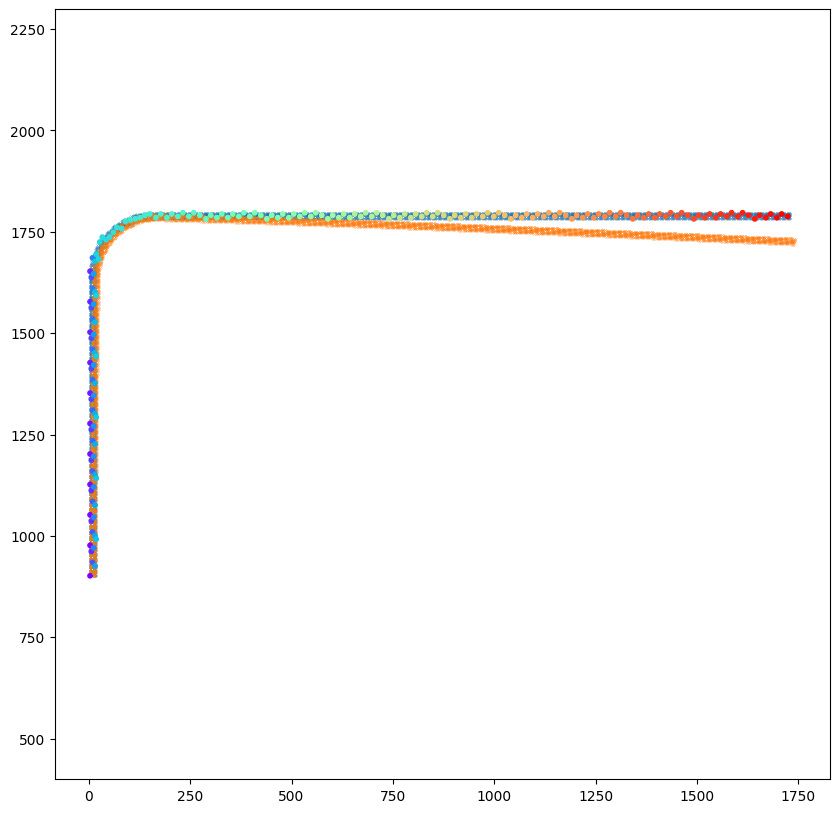

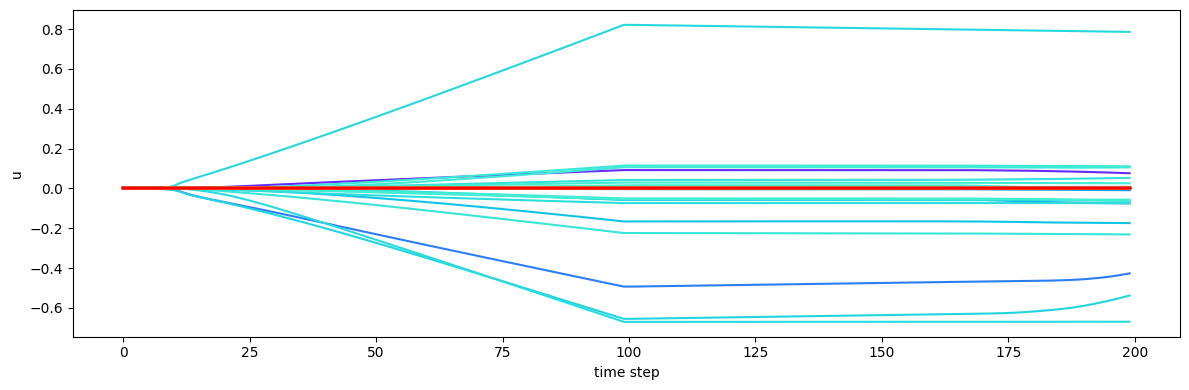

In [7]:
nodes = data['nodes']
timestep = 1
u_data = data['u_history'][timestep]
u_whole = torch.norm(data['u_history'],dim=2)
#u_derv = u_whole[1:]-u_whole[:-1]
u_derv = torch.diff(u_whole)

nodes_arange = torch.arange(0,len(nodes),100)
#nodes_smask = (nodes[nodes_arange,0] < 350) & (nodes[nodes_arange,1] > 1500)
#nodes_arange = nodes_arange[nodes_smask]
colors = plt.cm.rainbow(np.linspace(0, 1, len(nodes_arange)))

plt.figure(figsize=(10,10))
plt.scatter(nodes[:,0],nodes[:,1],s=0.01)
plt.scatter(nodes[:,0]+u_data[:,0],nodes[:,1]+u_data[:,1],s=0.01)
vals = np.linspace(0, 1, len(nodes_arange))  # ramp
plt.scatter(nodes[nodes_arange, 0], nodes[nodes_arange, 1],
            s=10, c=vals, cmap="rainbow")
plt.axis('equal')

plt.figure(figsize=(12,4))
plt.gca().set_prop_cycle(color=colors)
#plt.plot(u_whole[:, nodes_arange])  # one call, colors applied per column
plt.plot(u_derv[:, nodes_arange])  # one call, colors applied per column
plt.xlabel("time step"); plt.ylabel("u")
plt.tight_layout()
plt.show()

(np.float64(-86.5), np.float64(1816.5), np.float64(855.0), np.float64(1845.0))

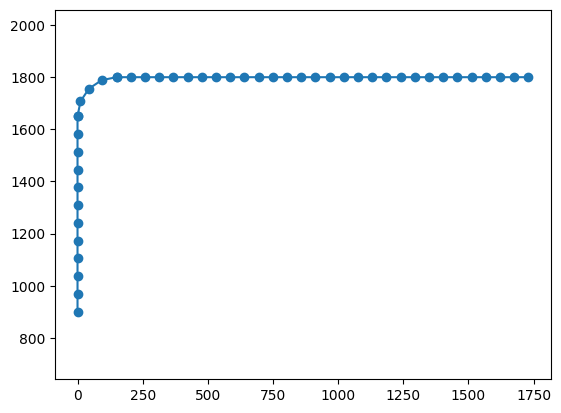

In [8]:
import numpy as np
from scipy.spatial import KDTree

def l_curve():
    r = 150.0
    x0, x1 = 00.0, 1730.0
    y0, y1 = 900.0, 1800.0
    n_line, n_arc = 30, 5
    n_line2 = 12

    # vertical: (150, 900) → (150, 1650 - r)
    p_v = np.column_stack([
        np.full(n_line2, x0),
        np.linspace(y0, y1 - r, n_line2),
    ])

    # fillet: center at (x0 + r, y1 - r), from angle π to π/2 (up then right)
    cx, cy = x0 + r, y1 - r
    theta = np.linspace(np.pi, np.pi/2, n_arc)
    p_arc = np.column_stack([
        cx + r * np.cos(theta),
        cy + r * np.sin(theta),
    ])

    # horizontal: (x0 + r, y1) → (1730, 1650)
    p_h = np.column_stack([
        np.linspace(x0 + r, x1, n_line),
        np.full(n_line, y1),
    ])

    xy = np.vstack([p_v, p_arc, p_h])
    pts3d = np.hstack([xy, np.zeros((len(xy), 1))])  # add z=0
    return pts3d

curve_pts = l_curve()  # (N,3)

plt.plot(curve_pts[:,0],curve_pts[:,1],'-o')
plt.axis('equal')

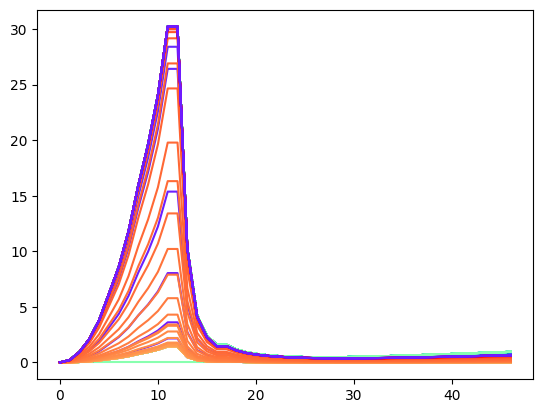

In [9]:
tree = KDTree(nodes[:,:2],leafsize=8)
slices = tree.query_ball_point(curve_pts[:,:2],r=10)
centroids_tsteps = []
for t in range(u_whole.shape[0]):
    centroids = [(nodes[bin]+data['u_history'][t][bin]).mean(axis=0) for bin in slices]
    centroids_tsteps.append(centroids)
centroids_tsteps = np.array(centroids_tsteps)
plt.gca().set_prop_cycle(color=colors)
for t in range(3,u_whole.shape[0]-1):
    centroids_diff = np.linalg.norm(centroids_tsteps[t]/centroids_tsteps[0]-centroids_tsteps[t-1]/centroids_tsteps[0],axis=1) #TODO
    plt.plot(centroids_diff)
#plt.ylim(0,500)

In [ ]:
#relative norms: node pos+u over t steps
pos_tsteps = nodes.repeat(data['u_history'].shape(0))+data['u_history']

#timestep plotted separately
#x axis node index

TypeError: 'torch.Size' object is not callable

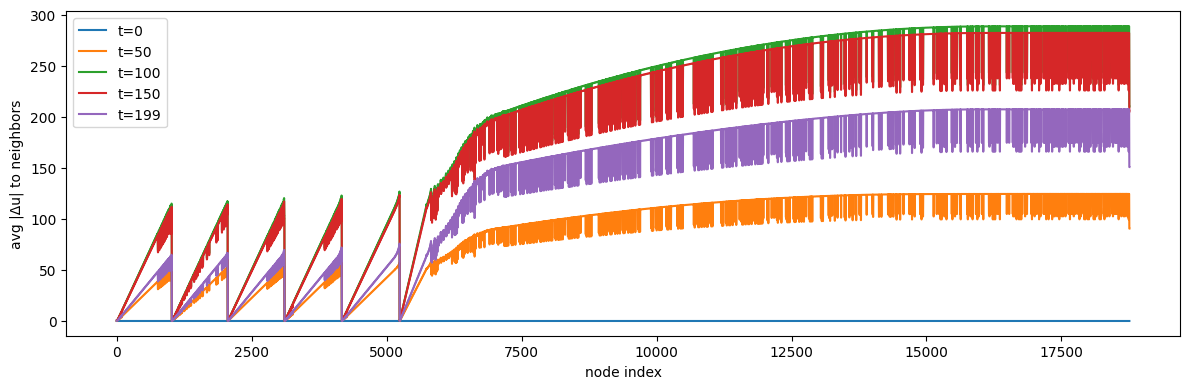

In [46]:
import torch, matplotlib.pyplot as plt

# assume edges is (E,2) neighbor list (build once via cdist or grid)
u_hist = data["u_history"]        # (T, N, d)
T, N, _ = u_hist.shape

xy = nodes[:, :2]

# infer spacing and build neighbor edges via cdist (simple)
hx = torch.mode(torch.diff(torch.unique(xy[:, 0]))).values
hy = torch.mode(torch.diff(torch.unique(xy[:, 1]))).values
step = float(min(hx, hy))
tol = 1e-6
dmat = torch.cdist(xy, xy)  # (N, N)
mask = (dmat > tol) & (dmat < step * 1.01)
i, j = torch.triu_indices(dmat.shape[0], dmat.shape[1], offset=1)
keep = mask[i, j]
edges = torch.stack((i[keep], j[keep]), dim=1)  # (E, 2)
node_strain_t = []
for t in range(T):
    u = u_hist[t]                                 # (N, d)
    rel = u[edges[:,1]] - u[edges[:,0]]           # (E, d)
    rel_norm = rel.norm(dim=1)                    # (E,)

    node_sum = torch.zeros(N, device=u.device, dtype=u.dtype)
    node_cnt = torch.zeros(N, device=u.device, dtype=u.dtype)

    # add each edge’s magnitude to both incident nodes
    edge_nodes = edges.view(-1)                   # (2E,)
    contrib = rel_norm.repeat_interleave(2)       # (2E,)
    node_sum.scatter_add_(0, edge_nodes, contrib)
    node_cnt.scatter_add_(0, edge_nodes, torch.ones_like(edge_nodes, dtype=node_sum.dtype))

    node_strain = node_sum / (node_cnt + 1e-9)    # (N,)
    node_strain_t.append(node_strain)

node_strain_t = torch.stack(node_strain_t)        # (T, N)

# plot node index on x, one curve per timestep (pick a few)
ts_to_plot = [0, T//4, T//2, 3*T//4, T-1]
plt.figure(figsize=(12,4))
for t in ts_to_plot:
    plt.plot(node_strain_t[t].cpu(), label=f"t={t}")
plt.xlabel("node index"); plt.ylabel("avg |Δu| to neighbors")
plt.legend()
plt.tight_layout()
plt.show()
